In [14]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import random
import shutil

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load the VGG16 model with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


58889256/58889256 [==============================] - 0s 0us/step


In [4]:
# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [5]:
# Add custom classification layers on top
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [6]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [15]:
def oversample_by_replication(base_path, threshold_class='happy'):

    # Identify classes
    classes = os.listdir(base_path)

    # Find the maximum number of samples
    max_samples = 0
    for emotion in classes:
        num_samples = len(os.listdir(os.path.join(base_path, emotion)))
        max_samples = max(max_samples, num_samples)

    # Calculate the threshold based on the 'happy' class
    threshold = max_samples

    # Replicate instances for each class
    for emotion in classes:
        source_path = os.path.join(base_path, emotion)
        num_samples = len(os.listdir(source_path))

        # Replicate instances until the threshold is reached
        while num_samples < threshold:
            # Randomly select an instance to replicate
            random_instance = random.choice(os.listdir(source_path))

            # Specify the destination path
            destination_path = os.path.join(base_path, emotion, f'replica_{num_samples}.jpg')

            # Copy the selected instance to the destination
            shutil.copy(os.path.join(source_path, random_instance), destination_path)

            num_samples += 1


oversample_by_replication(train_dir)


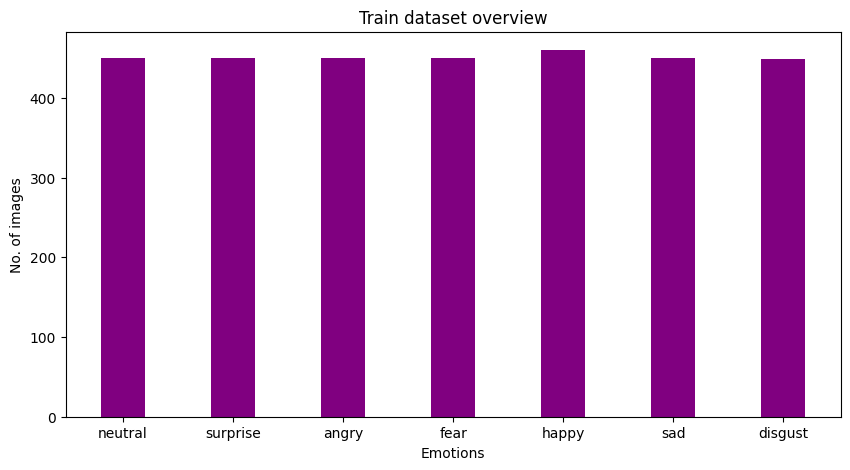

In [16]:
# Data visualisation
train_dir='/content/drive/MyDrive/archiveTL/train'
emotions = os.listdir(train_dir)
values = [len(os.listdir(f'/content/drive/MyDrive/archiveTL/train/{emotion}')) for emotion in emotions]
fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(emotions, values, color ='purple',
        width = 0.4)

plt.xlabel("Emotions")
plt.ylabel("No. of images")
plt.title("Train dataset overview")
plt.show()

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the path to your training data directory
train_data_dir = '/content/drive/MyDrive/archiveTL/train'

# Create an ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to be between 0 and 1
    shear_range=0.2,  # Shear transformations
    zoom_range=0.2,   # Random zoom
    horizontal_flip=True,  # Randomly flip images horizontally
    rotation_range=20,  # Random rotation
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    fill_mode='nearest'  # Fill mode for points outside the input boundary
)

# Set the input size according to VGG16 requirements (224x224)
img_size = (224, 224)

# Create an ImageDataGenerator for the test set (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Specify batch size
batch_size = 32

# Create generators for training and validation data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'  # Assuming you have categorical labels
)

# Set the path to your testing data directory
test_data_dir = '/content/drive/MyDrive/archiveTL/test'

# Create a generator for the test set
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3159 images belonging to 7 classes.
Found 2302 images belonging to 7 classes.


In [19]:
model.fit(train_generator, epochs=20, validation_data=test_generator)

Epoch 1/20
99/99 [==============================] - 578s 6s/step - loss: 2.2912 - accuracy: 0.2092 - val_loss: 1.8751 - val_accuracy: 0.2467
Epoch 2/20
99/99 [==============================] - 59s 597ms/step - loss: 1.8238 - accuracy: 0.2688 - val_loss: 1.7501 - val_accuracy: 0.3267
Epoch 3/20
99/99 [==============================] - 56s 562ms/step - loss: 1.7976 - accuracy: 0.2884 - val_loss: 1.8108 - val_accuracy: 0.2685
Epoch 4/20
99/99 [==============================] - 55s 560ms/step - loss: 1.7063 - accuracy: 0.3378 - val_loss: 1.6920 - val_accuracy: 0.3467
Epoch 5/20
99/99 [==============================] - 57s 578ms/step - loss: 1.6955 - accuracy: 0.3412 - val_loss: 1.6324 - val_accuracy: 0.3705
Epoch 6/20
99/99 [==============================] - 56s 561ms/step - loss: 1.6758 - accuracy: 0.3498 - val_loss: 1.7086 - val_accuracy: 0.3315
Epoch 7/20
99/99 [==============================] - 57s 568ms/step - loss: 1.6358 - accuracy: 0.3656 - val_loss: 1.6647 - val_accuracy: 0.3488
E

In [20]:
model.save("VGG.keras")